In [160]:
# trying to create some sort of new learning rate scheduler that can adapt

In [161]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [162]:
from sklearn.model_selection import train_test_split

In [163]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [164]:

def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [165]:
def get_uncompiled_model(model_name, model_params_dict):
    assert model_name in ['resnet', 'mscalev2', 'mscalev1', 'mscalev3']

    if model_name == 'resnet':
        model = wispy.resnet.ResNet(**model_params_dict)
    elif model_name == 'mscalev2':
        model = wispy.mscalev2.build_model(**model_params_dict)
    elif model_name == 'mscalev1':
        model = pugna.models.mscalednn.build_model_2(**model_params_dict)
    elif model_name == 'mscalev3':
        model = wispy.mscalev3.build_model(**model_params_dict)

    return model


def get_compiled_model(model_name, model_params_dict, extra_params_dict):
    model = get_uncompiled_model(
        model_name=model_name, model_params_dict=model_params_dict)

    optimizer = tf.keras.optimizers.Adam(
        extra_params_dict['lr'], amsgrad=extra_params_dict['amsgrad'])

    model.compile(loss=extra_params_dict['loss'],
                  optimizer=optimizer, metrics=extra_params_dict['metrics'])

    return model

# load data

In [166]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

X_train_raw = X_train_raw[:,0].reshape(-1, 1)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

X_train_raw.shape: (1119, 1)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 1)
y_train.shape: (749, 1)
X_val.shape: (370, 1)
y_val.shape: (370, 1)


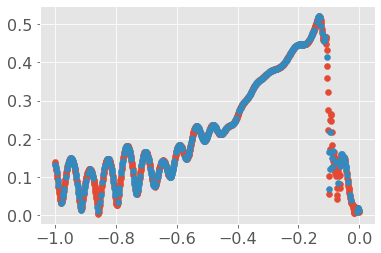

In [167]:
plt.figure()
plt.scatter(X_train, y_train)
plt.scatter(X_val, y_val)

# try a simple RNN

In [193]:
def build_rnn_model(units=32, reshape=(4,8)):
    input_shape = 1
    scale_dimension = 0
    dtype = "float32"

    input_layer = tf.keras.Input(shape=(input_shape,))


    scale_tensor_0 = wispy.mscalev3.make_scale_tensor(
        input_shape, scale_dimension, 1, dtype=dtype
    )
    scaled_input_0 = wispy.mscalev3.ScaleLayer(scale_tensor_0)(input_layer)

    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(scaled_input_0)
    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(x_0)
    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(x_0)
    x_0 = tf.keras.layers.Reshape(reshape)(x_0)
    # x_0 = tf.keras.layers.SimpleRNN(32, activation='s2relu', return_sequences=True)(x_0)
    x_0 = tf.keras.layers.SimpleRNN(units, activation='s2relu')(x_0)
    # x_0 = tf.keras.layers.LSTM(32, activation='s2relu')(x_0)
    # x_0 = tf.keras.layers.GRU(32, activation='s2relu')(x_0)

    scale_tensor_1 = wispy.mscalev3.make_scale_tensor(
        input_shape, scale_dimension, 10, dtype=dtype
    )
    scaled_input_1 = wispy.mscalev3.ScaleLayer(scale_tensor_1)(input_layer)

    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(scaled_input_1)
    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(x_1)
    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(x_1)
    x_1 = tf.keras.layers.Reshape(reshape)(x_1)
    # x_1 = tf.keras.layers.SimpleRNN(32, activation='s2relu', return_sequences=True)(x_1)
    x_1 = tf.keras.layers.SimpleRNN(units, activation='s2relu')(x_1)
    # x_1 = tf.keras.layers.LSTM(32, activation='s2relu')(x_1)
    # x_1 = tf.keras.layers.GRU(32, activation='s2relu')(x_1)


    scale_tensor_2 = wispy.mscalev3.make_scale_tensor(
        input_shape, scale_dimension, 100, dtype=dtype
    )
    scaled_input_2 = wispy.mscalev3.ScaleLayer(scale_tensor_2)(input_layer)

    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(scaled_input_2)
    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(x_2)
    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(x_2)
    x_2 = tf.keras.layers.Reshape(reshape)(x_2)
    # x_2 = tf.keras.layers.SimpleRNN(32, activation='s2relu', return_sequences=True)(x_2)
    x_2 = tf.keras.layers.SimpleRNN(units, activation='s2relu')(x_2)
    # x_2 = tf.keras.layers.Reshape((2,16))(x_2)
    # x_2 = tf.keras.layers.SimpleRNN(32, activation='s2relu')(x_2)

    output_layer = tf.keras.layers.add([x_0, x_1, x_2])

    output_layer = tf.keras.layers.Dense(1)(output_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [194]:
model = build_rnn_model()

In [169]:
# model = tf.keras.models.Sequential(
#     [
#         tf.keras.layers.InputLayer(input_shape=(1,)),
#         tf.keras.layers.Dense(4, activation='s2relu'),
#         tf.keras.layers.Reshape((2,2)),
#         tf.keras.layers.SimpleRNN(4, activation='s2relu'),
#         tf.keras.layers.Dense(1)
#     ]
# )

In [170]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_44 (ScaleLayer)     (None, 1)            0           input_17[0][0]                   
__________________________________________________________________________________________________
scale_layer_45 (ScaleLayer)     (None, 1)            0           input_17[0][0]                   
__________________________________________________________________________________________________
scale_layer_46 (ScaleLayer)     (None, 1)            0           input_17[0][0]                   
___________________________________________________________________________________________

In [171]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(loss='mse', optimizer=optimizer)


In [172]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=100, min_lr=1e-5, factor=0.8, cooldown=10)]

In [173]:
print("starting fit")
starttime = datetime.datetime.now()
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=callbacks
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit
Epoch 1/1000
24/24 [==============================] - 3s 19ms/step - loss: 0.0590 - val_loss: 0.0279
Epoch 2/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0031
Epoch 3/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 4/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/1000
24/24 [==============================] - 0s 4ms/step - loss: 9.1546e-04 - val_loss: 0.0011
Epoch 7/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/1000
24/24 [==============================] - 0s 4ms/step - loss: 9.8092e-04 - val_loss: 0.0010
Epoch 9/1000
24/24 [==============================] - 0s 4ms/step - loss: 9.4528e-04 - val_loss: 9.4189e-04
Epoch 10/1000
24/24 [==============================] - 0s 4ms/step - l

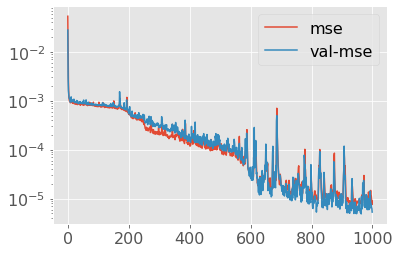

In [174]:
plt.figure()
plt.plot(history.history['loss'], label='mse')
plt.plot(history.history['val_loss'], label='val-mse')
plt.yscale('log')
plt.legend()

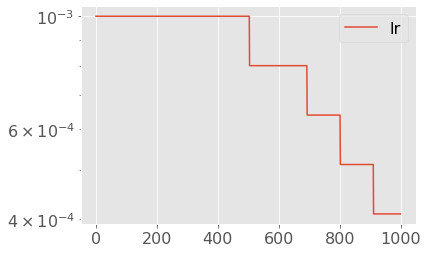

In [175]:
plt.figure()
plt.plot(history.history['lr'], label='lr')
plt.yscale('log')
plt.legend()

In [176]:
yhat = model.predict(X_train_raw)

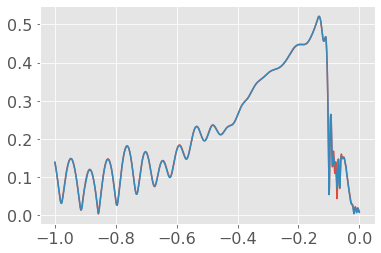

In [177]:
plt.figure()
plt.plot(X_train_raw[:,0], y_train_raw[:,0])
plt.plot(X_train_raw[:,0], yhat[:,0])

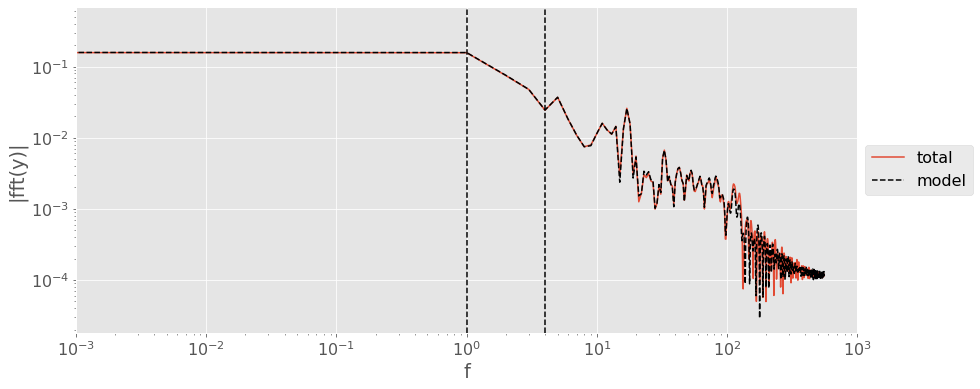

In [178]:
plot_fft(X_train_raw, y_train_raw, model=model, xlim=(1e-3, 1e3), logx=True, logy=True)

# without RNN

In [195]:
def build_model(units=32):
    input_shape = 1
    scale_dimension = 0
    dtype = "float32"

    input_layer = tf.keras.Input(shape=(input_shape,))


    scale_tensor_0 = wispy.mscalev3.make_scale_tensor(
        input_shape, scale_dimension, 1, dtype=dtype
    )
    scaled_input_0 = wispy.mscalev3.ScaleLayer(scale_tensor_0)(input_layer)

    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(scaled_input_0)
    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(x_0)
    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(x_0)
    x_0 = tf.keras.layers.Dense(units, activation='s2relu')(x_0)

    scale_tensor_1 = wispy.mscalev3.make_scale_tensor(
        input_shape, scale_dimension, 10, dtype=dtype
    )
    scaled_input_1 = wispy.mscalev3.ScaleLayer(scale_tensor_1)(input_layer)

    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(scaled_input_1)
    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(x_1)
    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(x_1)
    x_1 = tf.keras.layers.Dense(units, activation='s2relu')(x_1)

    scale_tensor_2 = wispy.mscalev3.make_scale_tensor(
        input_shape, scale_dimension, 100, dtype=dtype
    )
    scaled_input_2 = wispy.mscalev3.ScaleLayer(scale_tensor_2)(input_layer)

    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(scaled_input_2)
    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(x_2)
    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(x_2)
    x_2 = tf.keras.layers.Dense(units, activation='s2relu')(x_2)
    
    output_layer = tf.keras.layers.add([x_0, x_1, x_2])

    output_layer = tf.keras.layers.Dense(1)(output_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [196]:
model_2 = build_model()

In [180]:
model_2.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_47 (ScaleLayer)     (None, 1)            0           input_18[0][0]                   
__________________________________________________________________________________________________
scale_layer_48 (ScaleLayer)     (None, 1)            0           input_18[0][0]                   
__________________________________________________________________________________________________
scale_layer_49 (ScaleLayer)     (None, 1)            0           input_18[0][0]                   
___________________________________________________________________________________________

In [181]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model_2.compile(loss='mse', optimizer=optimizer)


In [182]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=100, min_lr=1e-5, factor=0.8, cooldown=10)]

In [183]:
print("starting fit")
starttime = datetime.datetime.now()
history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=callbacks
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit
Epoch 1/1000
24/24 [==============================] - 1s 10ms/step - loss: 0.0568 - val_loss: 0.0257
Epoch 2/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0173 - val_loss: 0.0026
Epoch 3/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 4/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/1000
24/24 [==============================] - 0s 2ms/step - loss: 9.9945e-04 - val_loss: 0.0011
Epoch 8/1000
24/24 [==============================] - 0s 2ms/step - loss: 9.0713e-04 - val_loss: 0.0011
Epoch 9/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/1000
24/24 [==============================] - 0s 2ms/step - loss: 9.4

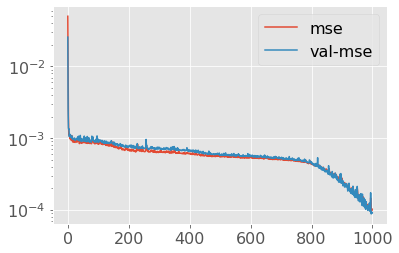

In [184]:
plt.figure()
plt.plot(history_2.history['loss'], label='mse')
plt.plot(history_2.history['val_loss'], label='val-mse')
plt.yscale('log')
plt.legend()

In [185]:
plt.figure()
plt.plot(history_2.history['lr'], label='lr')
plt.yscale('log')
plt.legend()

In [186]:
yhat_2 = model_2.predict(X_train_raw)

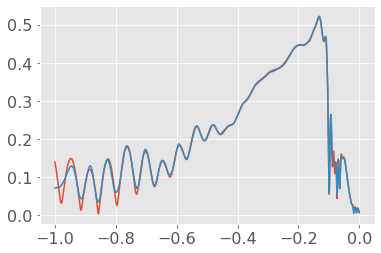

In [187]:
plt.figure()
plt.plot(X_train_raw[:,0], y_train_raw[:,0])
plt.plot(X_train_raw[:,0], yhat_2[:,0])

In [188]:
plot_fft(X_train_raw, y_train_raw, model=model_2, xlim=(1e-3, 1e3), logx=True, logy=True)

# comparison

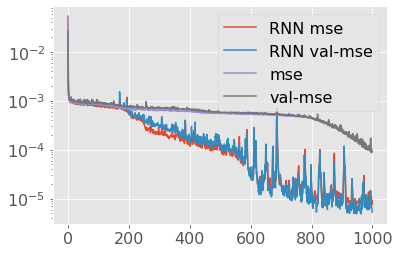

In [189]:
plt.figure()
plt.plot(history.history['loss'], label='RNN mse')
plt.plot(history.history['val_loss'], label='RNN val-mse')


plt.plot(history_2.history['loss'], label='mse')
plt.plot(history_2.history['val_loss'], label='val-mse')
plt.yscale('log')
plt.legend()

In [190]:
plt.figure()
plt.plot(history.history['lr'], label='RNN lr')
plt.plot(history_2.history['lr'], label='lr')
plt.yscale('log')
plt.legend()

In [191]:
plt.figure(figsize=(14,8))
plt.plot(X_train_raw[:,0], yhat[:,0], label='rnn')
plt.plot(X_train_raw[:,0], yhat_2[:,0], label='no rnn')
plt.plot(X_train_raw[:,0], y_train_raw[:,0], label='data', c='k', ls='--')
plt.legend()

(-0.2, 0.0)

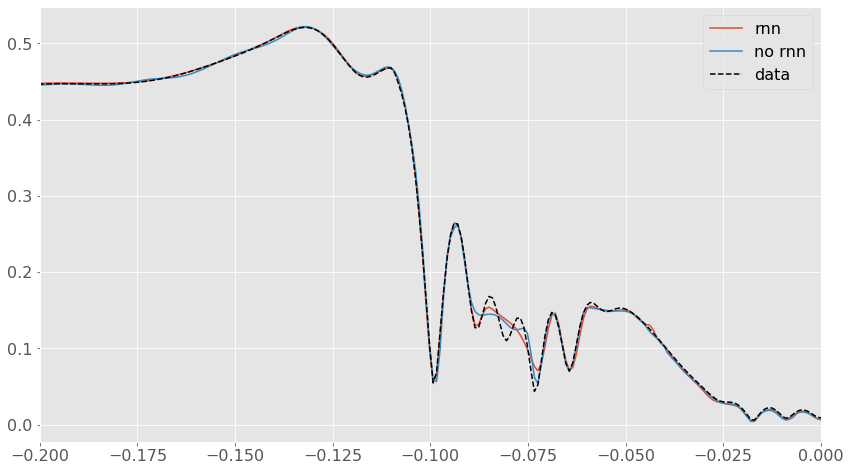

In [192]:
plt.figure(figsize=(14,8))
plt.plot(X_train_raw[:,0], yhat[:,0], label='rnn')
plt.plot(X_train_raw[:,0], yhat_2[:,0], label='no rnn')
plt.plot(X_train_raw[:,0], y_train_raw[:,0], label='data', c='k', ls='--')
plt.legend()
plt.xlim(-0.2, 0)

# loop over to get some stats

## rnn model

In [263]:
n_tries = 1
epochs = 1000
# batch_size = 32
batch_size = X_train.shape[0]

In [264]:
rnn_models = []
rnn_historys = []
for n in range(n_tries):
    print("\n====\n")
    print(f"iter: {n}")
    print("\n====\n")
    rnn_model = build_rnn_model(units=256, reshape=(64, 4))
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    rnn_model.compile(loss='mse', optimizer=optimizer)
    
    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=100, min_lr=1e-5, factor=0.8, cooldown=10)]
    
    print("starting fit")
    starttime = datetime.datetime.now()
    rnn_history = rnn_model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime

    print("")
    print("fit complete")
    print(f"The time cost: {duration}")
    
    rnn_models.append(rnn_model)
    rnn_historys.append(rnn_history)


====

iter: 0

====

starting fit
Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0645 - val_loss: 0.0618
Epoch 2/1000
1/1 [==============================] - 1s 763ms/step - loss: 0.0637 - val_loss: 0.0606
Epoch 3/1000
1/1 [==============================] - 1s 695ms/step - loss: 0.0624 - val_loss: 0.0589
Epoch 4/1000
1/1 [==============================] - 1s 724ms/step - loss: 0.0608 - val_loss: 0.0573
Epoch 5/1000
1/1 [==============================] - 1s 758ms/step - loss: 0.0592 - val_loss: 0.0556
Epoch 6/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.0576 - val_loss: 0.0534
Epoch 7/1000
1/1 [==============================] - 1s 673ms/step - loss: 0.0554 - val_loss: 0.0506
Epoch 8/1000
1/1 [==============================] - 1s 700ms/step - loss: 0.0525 - val_loss: 0.0471
Epoch 9/1000
1/1 [==============================] - 1s 683ms/step - loss: 0.0490 - val_loss: 0.0434
Epoch 10/1000
1/1 [==============================] - 1s 904ms/step -

In [265]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
for i, h in enumerate(rnn_historys):
    plt.plot(h.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=3)

plt.subplot(1, 3, 2)
for i, h in enumerate(rnn_historys):
    plt.plot(h.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=3)

plt.subplot(1, 3, 3)
for i, h in enumerate(rnn_historys):
    plt.plot(h.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=3)

## non-rnn model

In [254]:
n_tries = 10
epochs = 1000
batch_size = 32

In [255]:
base_models = []
base_historys = []
for n in range(n_tries):
    print("\n====\n")
    print(f"iter: {n}")
    print("\n====\n")
    base_model = build_model(units=256)
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    base_model.compile(loss='mse', optimizer=optimizer)
    
    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=100, min_lr=1e-5, factor=0.8, cooldown=10)]
    
    print("starting fit")
    starttime = datetime.datetime.now()
    base_history = base_model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime

    print("")
    print("fit complete")
    print(f"The time cost: {duration}")
    
    base_models.append(base_model)
    base_historys.append(base_history)


====

iter: 0

====

starting fit

fit complete
The time cost: 0:01:33.359137

====

iter: 1

====

starting fit

fit complete
The time cost: 0:01:33.763309

====

iter: 2

====

starting fit

fit complete
The time cost: 0:01:35.489707

====

iter: 3

====

starting fit

fit complete
The time cost: 0:01:33.729373

====

iter: 4

====

starting fit

fit complete
The time cost: 0:01:33.679568

====

iter: 5

====

starting fit

fit complete
The time cost: 0:01:34.535730

====

iter: 6

====

starting fit

fit complete
The time cost: 0:01:34.484335

====

iter: 7

====

starting fit

fit complete
The time cost: 0:01:33.813687

====

iter: 8

====

starting fit

fit complete
The time cost: 0:01:34.371743

====

iter: 9

====

starting fit

fit complete
The time cost: 0:01:33.753998


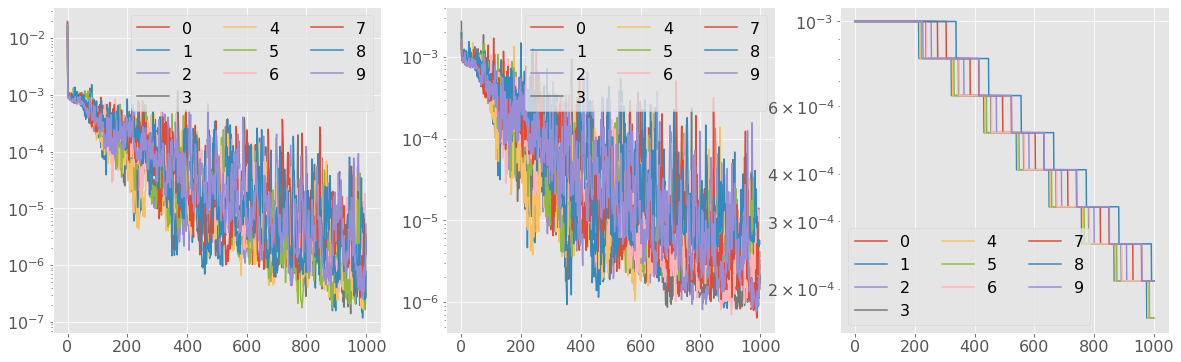

In [256]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
for i, h in enumerate(base_historys):
    plt.plot(h.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=3)

plt.subplot(1, 3, 2)
for i, h in enumerate(base_historys):
    plt.plot(h.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=3)

plt.subplot(1, 3, 3)
for i, h in enumerate(base_historys):
    plt.plot(h.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=3)

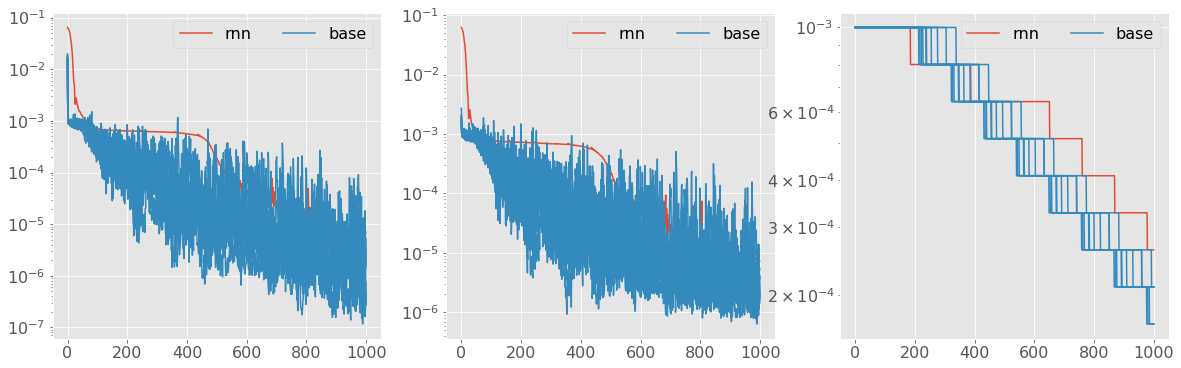

In [266]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
for i, h in enumerate(rnn_historys):
    if i == 0:
        plt.plot(h.history['loss'], label='rnn', c='C0')
    else:
        plt.plot(h.history['loss'], c='C0')
for i, h in enumerate(base_historys):
    if i == 0:
        plt.plot(h.history['loss'], label='base', c='C1')
    else:
        plt.plot(h.history['loss'], c='C1')
plt.yscale('log')
plt.legend(ncol=3)

plt.subplot(1, 3, 2)
for i, h in enumerate(rnn_historys):
    if i == 0:
        plt.plot(h.history['val_loss'], label='rnn', c='C0')
    else:
        plt.plot(h.history['val_loss'], c='C0')
for i, h in enumerate(base_historys):
    if i == 0:
        plt.plot(h.history['val_loss'], label='base', c='C1')
    else:
        plt.plot(h.history['val_loss'], c='C1')
plt.yscale('log')
plt.legend(ncol=3)

plt.subplot(1, 3, 3)
for i, h in enumerate(rnn_historys):
    if i == 0:
        plt.plot(h.history['lr'], label='rnn', c='C0')
    else:
        plt.plot(h.history['lr'], c='C0')
for i, h in enumerate(base_historys):
    if i == 0:
        plt.plot(h.history['lr'], label='base', c='C1')
    else:
        plt.plot(h.history['lr'], c='C1')
plt.yscale('log')
plt.legend(ncol=3)